# Automatic Apparent Age Estimation - Bias Reduction 

In [1]:
import pathlib
import pickle
import random
import zipfile

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.layers import (
    BatchNormalization, Dense, Dropout, Flatten)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import (
    random_brightness, random_rotation, random_shift, random_zoom,
)

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
root_dir = pathlib.Path('.')

Mounted at /content/gdrive


## Helper functions

In [3]:
# Dataset load and preprocess.
def load_data(stage: str):
    return (
        np.load(f'./data/data_{stage}.npy'),
        np.load(f'./data/labels_{stage}.npy'),
        np.load(f'./data/meta_data_{stage}.npy'),
    )

def preprocess_X(X) -> None:
    """Preprocess samples so they can be used as
     ResNET50 inputs."""
    for i in range(0, X.shape[0]):
        x = X[i,:,:,:]
        x = np.expand_dims(x, axis=0)
        X[i,] = preprocess_input(x)

In [4]:
# Training and model evalueation.
def plot_train_history(train_history):
    """Plot learnign curves from the training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

    ax1.plot(train_history['loss'])
    ax1.plot(train_history['val_loss'])
    ax1.set(xlabel='epoch', ylabel='LOSS')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_history['mae'])
    ax2.plot(train_history['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.show()

In [5]:
def evaluate_model(model: Model):
    predictions = model.predict(X_test, batch_size=32, verbose=1)

    # evaluating on test data
    predictions_f = predictions*100
    error = []
    for i in range(len(Y_test)):
        error.append(
            abs(np.subtract(predictions_f[i][0], Y_test[i])),
        )
    print(f'MAE = {np.mean(error):.8f}')
    return predictions_f

# Downloading and decompressing the Appa-Real Age Dataset [(source)](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)

In [6]:
if not pathlib.Path(root_dir / 'app_data.zip').exists():
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

with zipfile.ZipFile(root_dir / 'app_data.zip','r') as zip_file:
    zip_file.extractall()
    print('Data decompressed successfully')

# !rm app_data.zip

Data decompressed successfully


# Loading the dataset

In [11]:
# loading the train data
X_train, Y_train, M_train = load_data('train')
# loading the validation data
X_valid, Y_valid, M_valid  = load_data('valid')
# loading the test data
X_test, Y_test, M_test = load_data('test')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train, Y_valid = Y_train/100, Y_valid/100

# Transform the dataset so it works with the ResNet.
# preprocess_X(X_train)
# preprocess_X(X_valid)
# preprocess_X(X_test)

print(f"Train set ::: X : {X_train.shape}, "
      f"Y : {Y_train.shape}, M : {M_train.shape}")
print(f"Valid set ::: X : {X_valid.shape}, "
      f"Y : {Y_valid.shape}, M : {M_valid.shape}")
print(f"Test set ::: X : {X_test.shape}, "
      f"Y : {Y_test.shape}, M : {M_test.shape}")

Train set ::: X : (4065, 224, 224, 3), Y : (4065,), M : (4065, 3)
Valid set ::: X : (1482, 224, 224, 3), Y : (1482,), M : (1482, 3)
Test set ::: X : (1978, 224, 224, 3), Y : (1978,), M : (1978, 3)


## Visualizing some training samples

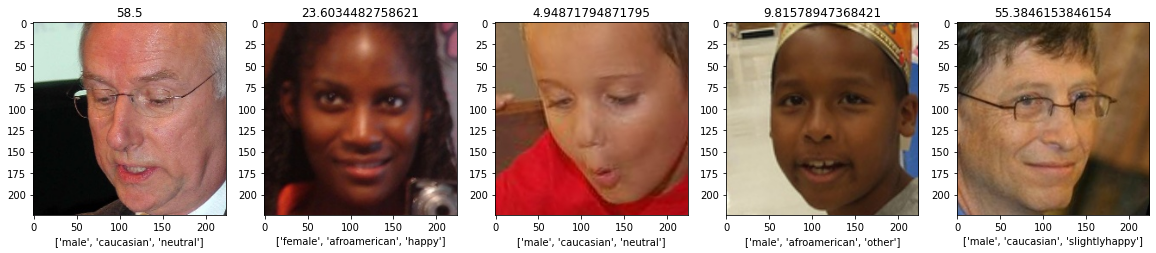

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])

### Visualizing the age distribution of Train data

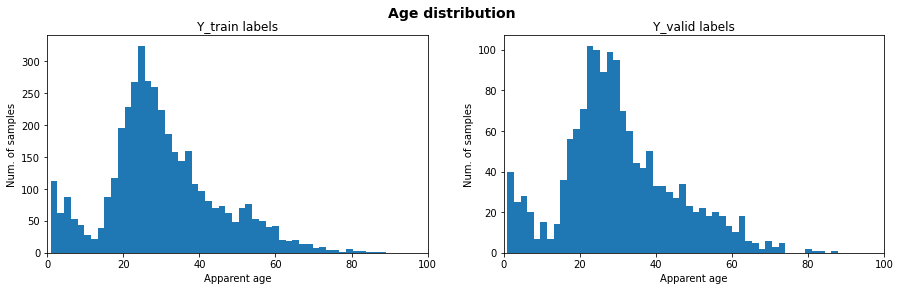

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])
plt.show()

### Visualizing the distributions of metadata (Train data)

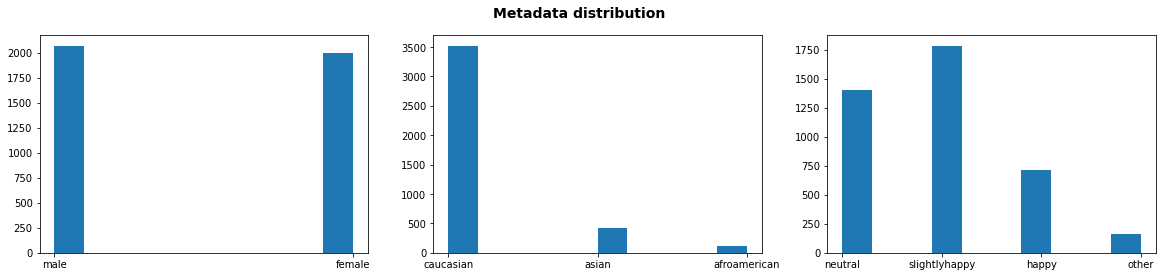

In [14]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
    gender.append(sample[0])
    etnhicity.append(sample[1])
    emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)
plt.show()

### Visualizing the age distribution per ethnicity

In [15]:
def compute_hist_per_ethnicity(y_data, metadata, label):
    age_per_eth = {
        'asian': [],
        'afroamerican': [],
        'caucasian': [],
    }
    for meta, y in zip(metadata, y_data):
        age_per_eth[meta[1]].append(y)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(f'Age distribution per Ethnicity {label}',
                 fontsize=14, fontweight='bold')

    ax1.hist(age_per_eth['asian'], bins=50)
    ax1.set_xlim([0, 100])
    ax1.set(xlabel='Asian', ylabel='Num. of samples')

    ax2.hist(age_per_eth['afroamerican'], bins=50)
    ax2.set_xlim([0, 100])
    ax2.set(xlabel='Afroamerican', ylabel='Num. of samples')

    ax3.hist(age_per_eth['caucasian'], bins=50) 
    ax3.set_xlim([0, 100])
    ax3.set(xlabel='Caucasian', ylabel='Num. of samples')
    plt.show()

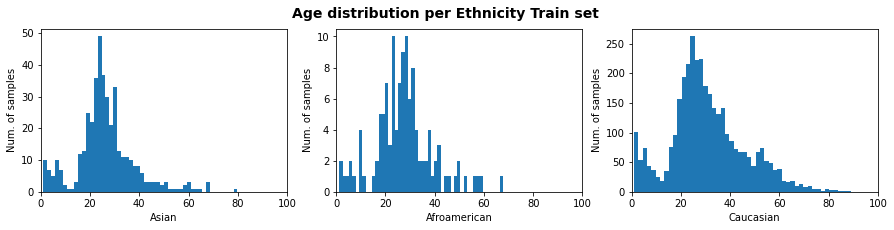

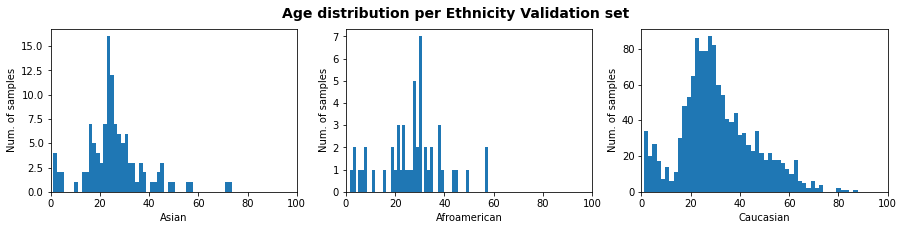

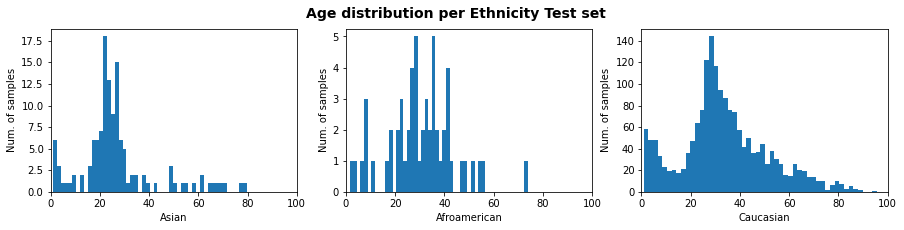

In [16]:
compute_hist_per_ethnicity(Y_train*100, M_train, 'Train set')
compute_hist_per_ethnicity(Y_valid*100, M_valid, 'Validation set')
compute_hist_per_ethnicity(Y_test, M_test, 'Test set')

---
# Bias functions definitions.
The amount of samples representing different groups in the dataset is clearly visible. In this exercise a number of methods will be used to evaluate and guide the model towards unbiased age estimation. At this stage, the main goal is not to achieve the best accuracy score but to check how various methods impact the process of training. 

Below, the functions to estimate the bias made by the model are defined. Having the metadata attached to the dataset, it is possible to compute the following:
  - Age bias
  - Gender bias
  - Ethnicity bias
  - Facial Expression bias

Given a particular attribute, we compute the MAE for different groups. For the case of age, detailed next, we will have 4 groups base on different age ranges. Then, we will have $MAE_1$, $MAE_2$, $MAE_3$ and $MAE_4$. Then, we compute the Absolute Difference among all. That is,
  - $D_{1,2} = |MAE_1-MAE_2|$
  - $D_{1,3} = |MAE_1-MAE_3|$
  - $D_{1,4} = |MAE_1-MAE_4|$
  - $D_{2,3} = |MAE_2-MAE_3|$
  - $D_{2,4} = |MAE_2-MAE_4|$
  - $D_{3,4} = |MAE_3-MAE_4|$

The final score is obtained by the average of the absolute differentes. In the case of age:
  - $B_a = (D_{1,2} + D_{1,3} + D_{1,4} + D_{2,3} + D_{2,4} + D_{3,4})/6$

## Age Bias ($B_a$)

In [29]:
def age_bias(predictions, gt):
    error_g1 = []
    error_g2 = []
    error_g3 = []
    error_g4 = []
    for i in range(len(gt)):
        if gt[i] < 20:
            error_g1.append(abs(predictions[i] - gt[i]))
        elif 20 <= gt[i] < 40:
            error_g2.append(abs(predictions[i] - gt[i]))
        elif 40 <= gt[i] < 60:
            error_g3.append(abs(predictions[i] - gt[i]))
        elif gt[i] >= 60:
            error_g4.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Age analysis:')
    print(f'Size group 1 = {len(error_g1)}, MAE = {np.mean(error_g1)}')
    print(f'Size group 2 = {len(error_g2)}, MAE = {np.mean(error_g2)}')
    print(f'Size group 3 = {len(error_g3)}, MAE = {np.mean(error_g3)}')
    print(f'Size group 4 = {len(error_g4)}, MAE = {np.mean(error_g4)}')

    age_bias = sum((
        abs(np.mean(error_g1) - np.mean(error_g2)),
        abs(np.mean(error_g1) - np.mean(error_g3)),
        abs(np.mean(error_g1) - np.mean(error_g4)),
        abs(np.mean(error_g2) - np.mean(error_g3)),
        abs(np.mean(error_g2) - np.mean(error_g4)),
        abs(np.mean(error_g3) - np.mean(error_g4)),
    )) / 6

    print('---------')
    print(f'Age bias (Ba) = {age_bias}')

## Gender Bias ($B_g$) 
Evaluates (on the test set) how accurate the model is with respect to gender.

In [30]:
def gender_bias(predictions, gt, metadata):
    error_m = []
    error_f = []
    for i in range(len(gt)):
        if metadata[i][0] == 'female':
            error_f.append(abs(predictions[i] - gt[i]))
        else:
            error_m.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Gender analysis:')
    print(f'Size group female = {len(error_f)}, MAE = {np.mean(error_f)}')
    print(f'Size group male = {len(error_m)}, MAE = {np.mean(error_m)}')

    gender_bias = abs(np.mean(error_f) - np.mean(error_m))

    print('---------')
    print(f'Gender bias (Bg) = {gender_bias}')

## Ethnicity Bias ($B_e$)
Evaluates (on the test set) how accurate the model is with respect to ethnicity category.

In [31]:
def ethnicity_bias(predictions, gt, metadata):
    error_as = []
    error_af = []
    error_ca = []
    for i in range(len(gt)):
        if metadata[i][1] == 'asian':
            error_as.append(abs(predictions[i] - gt[i]))
        elif metadata[i][1] == 'afroamerican':
            error_af.append(abs(predictions[i] - gt[i]))
        elif metadata[i][1] == 'caucasian':
            error_ca.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Ethnicity Analysis:')
    print(f'Size group asian = {len(error_as)}, MAE = {np.mean(error_as)}')
    print(f'Size group afroamerican = {len(error_af)}, MAE = {np.mean(error_af)}')
    print(f'Size group caucasian = {len(error_ca)}, MAE = {np.mean(error_ca)}')

    ethnicity_bias = sum((
        abs(np.mean(error_as) - np.mean(error_af)),
        abs(np.mean(error_as) - np.mean(error_ca)),
        abs(np.mean(error_af) - np.mean(error_ca)),
    )) / 3

    print('---------')
    print(f'Ethnicity bias (Be) = {ethnicity_bias}')

## Face expression bias ($B_f$)
Evaluates (on the test set) how accurate the model is with respect to face expression categories.

In [32]:
def face_expression_bias(predictions, gt, metadata):
    error_h = []
    error_s = []
    error_n = []
    error_o = []
    for i in range(len(gt)):
        if metadata[i][2] == 'happy':
            error_h.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'slightlyhappy':
            error_s.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'neutral':
            error_n.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'other':
            error_o.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Face experession Analysis:')
    print(f'Size group happy = {len(error_h)}, MAE = {np.mean(error_h)}')
    print(f'Size group slightlyhappy = {len(error_s)}, MAE = {np.mean(error_s)}')
    print(f'Size group neutral = {len(error_n)}, MAE = {np.mean(error_n)}')
    print(f'Size group other = {len(error_o)}, MAE = {np.mean(error_o)}')

    face_bias = sum((
        abs(np.mean(error_h) - np.mean(error_s)),
        abs(np.mean(error_h) - np.mean(error_n)),
        abs(np.mean(error_h) - np.mean(error_o)),
        abs(np.mean(error_s) - np.mean(error_n)),
        abs(np.mean(error_s) - np.mean(error_o)),
        abs(np.mean(error_n) - np.mean(error_o)),
    ))/6

    print('---------')
    print('Face Expression bias (Bf) = ', face_bias)

---
---
# Strategies to improve Accuracy

## Data augmentation
We will augment the train set of people having age >= 60, as this group got the highest MAE compared to the other groups (regarding the age attribute only).

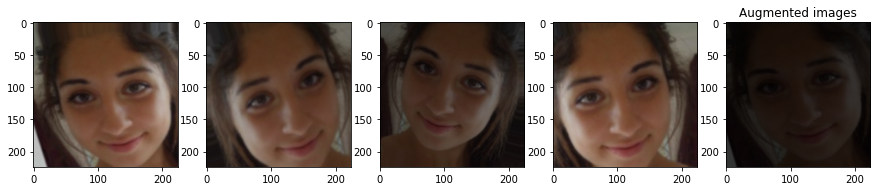

In [21]:
# Loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')

# Randomly selecting a random image from train set, to perform augmentation on it.
x = X_train[random.randint(0, len(X_train))]

#Image augmentation function
def augmentation(image):
    # Apply random brightness shift
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:,:,2] = image[:,:,2] * random.uniform(0.2,1) 
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    # Random rotation within 20 degrees. 
    image = random_rotation(image, 20, row_axis=0, col_axis=1, channel_axis=2)
    # Random shift.
    image = random_shift(image, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2)
    # Random zoom.
    image = random_zoom(image, (0.85, 1), row_axis=0, col_axis=1, channel_axis=2)

    # Random application of gaussian blur.
    kernel = random.choice([1,3,5]) 
    image = cv2.GaussianBlur(image,(kernel, kernel),1)
    # Random vertical flipping. 
    if random.random() < 0.5:
        image = image[:,::-1,:]
    return image

# Visualizing the augmented data
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
plt.title('Augmented images')
for ax in axes:
    ax.imshow(cv2.cvtColor(augmentation(x), cv2.COLOR_BGR2RGB))

### Applying the data augmentation described above
Applying to create more balanced dataset - creating additional samples of underrepresented groups.

In [22]:
#Lists with augmented data
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

# Loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')
Y_train = Y_train/100
print('Dimensions of the train set before augmentation:" ', np.array(X_train).shape)

# Sizes of each of the subsets regarding the age range, i.e. number of images in the training set that belongs to each of the age range
# Number of images within the age range (0, 20)
Size1 =np.size(np.where(Y_train*100<20))
# Number of images within the age range (20, 40)
Size2 = np.size(np.where(np.logical_and(Y_train*100>=20 , Y_train*100<40)))
#Number of images within the age range (40, 60)
Size3 = np.size(np.where(np.logical_and(Y_train*100>=40 , Y_train*100<60)))
# Number of images within the age range (60, 100)
Size4 = np.size(np.where(Y_train*100>=60))

# The subset with the age range (0, 20) contains the majority of training examples. 
# Thus, we will perform the data augmentation on all other age range subsets, 
# in order to balance out the number of samples within each age range.
# The number of times we need to perform data augmentation on an image, 
# for the images in ranges (0,20), (40, 60), (60, 100) respectively.
N_aug = [int(Size2/Size1)-1, int(Size2/Size3)-1, int(Size2/Size4)-1]
print('Number of images within the age range (0, 20): ', 
      Size1, 'each will be augmented ', N_aug[0], ' times.')
print('Number of images within the age range (20, 40): ', Size2)
print('Number of images within the age range (40, 60): ', 
      Size3,'; each will be augmented ', N_aug[1], ' times' )
print('Number of images within the age range (60, 100)', 
      Size4, '; each will be augmented ', N_aug[2], ' times.')

#Augmenting the images with respect to the age range they belong to
for i in range(len(X_train)):
    age = Y_train[i]*100
    # check if image is in the group 'age < 20' 
    # and perform augmentation N_aug[0] times
    if age < 20: 
        X_train_augmented.extend([augmentation(X_train[i]) for _ in range(N_aug[0])])
        Y_train_augmented.extend([Y_train[i]] * N_aug[0])
        M_train_augmented.extend([M_train[i]] * N_aug[0])
    # check if image is in the group '40 < age < 60' 
    # and perform augmentation N_aug[1] times
    elif 40 <= age < 60: 
        X_train_augmented.extend([augmentation(X_train[i]) for _ in range(N_aug[1])])
        Y_train_augmented.extend([Y_train[i]] * N_aug[1])
        M_train_augmented.extend([M_train[i]] * N_aug[1])
    # check if image is in the group '60< age < 100' 
    # and perform augmentation N_aug[2] times
    elif age >= 60: 
        X_train_augmented.extend([augmentation(X_train[i]) for _ in range(N_aug[2])])
        Y_train_augmented.extend([Y_train[i]] * N_aug[2])
        M_train_augmented.extend([M_train[i]] * N_aug[2])  

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)

preprocess_X(X_train)

Dimensions of the train set before augmentation:"  (4065, 224, 224, 3)
Number of images within the age range (0, 20):  796 each will be augmented  2  times.
Number of images within the age range (20, 40):  2389
Number of images within the age range (40, 60):  732 ; each will be augmented  2  times
Number of images within the age range (60, 100) 148 ; each will be augmented  15  times.
Train set after augmentation =  (9341, 224, 224, 3)


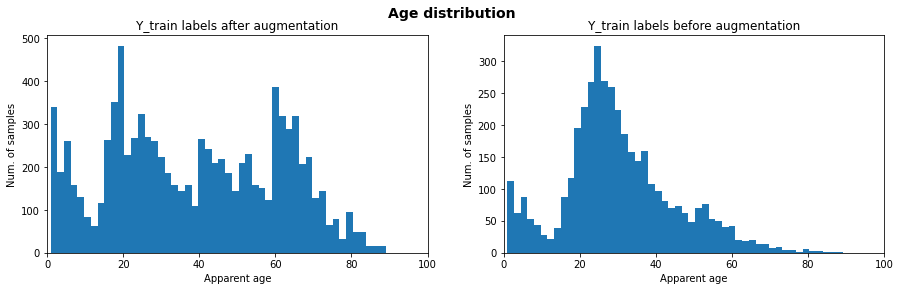

In [23]:
Y_train_original = np.load('./data/labels_train.npy')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels after augmentation')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_train_original, bins = 50)
ax2.set_title('Y_train labels before augmentation')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])
plt.show()
del Y_train_original

### Train the model with the augmented data

In [26]:
saved_model = load_model(root_dir / 'model_checkpoint_2.h5')
saved_model.trainable = True

es = EarlyStopping(
    monitor='val_mae', 
    mode='min', 
    verbose=1, 
    patience=10,
)
mc = ModelCheckpoint(
    'aug_model_checkpoint.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae'],
)

history = saved_model.fit(
    X_train, Y_train,  
    validation_data=(X_valid, Y_valid), 
    batch_size=16, 
    epochs=10, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

with open('train_history_aug.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
584/584 [==============================] - 127s 183ms/step - loss: 0.1833 - mae: 0.0892 - val_loss: 0.1668 - val_mae: 0.0853 - lr: 1.0000e-04
Epoch 2/10
584/584 [==============================] - 102s 175ms/step - loss: 0.1495 - mae: 0.0726 - val_loss: 0.1411 - val_mae: 0.0948 - lr: 1.0000e-04
Epoch 3/10
584/584 [==============================] - 106s 181ms/step - loss: 0.1257 - mae: 0.0749 - val_loss: 0.1120 - val_mae: 0.0544 - lr: 1.0000e-04
Epoch 4/10
584/584 [==============================] - 103s 176ms/step - loss: 0.1039 - mae: 0.0657 - val_loss: 0.0953 - val_mae: 0.0654 - lr: 1.0000e-04
Epoch 5/10
584/584 [==============================] - 102s 175ms/step - loss: 0.0860 - mae: 0.0614 - val_loss: 0.0797 - val_mae: 0.0630 - lr: 1.0000e-04
Epoch 6/10
584/584 [==============================] - 102s 174ms/step - loss: 0.0794 - mae: 0.0759 - val_loss: 0.0935 - val_mae: 0.1309 - lr: 1.0000e-04
Epoch 7/10
584/584 [==============================] - 102s 174ms/step - loss: 0.06

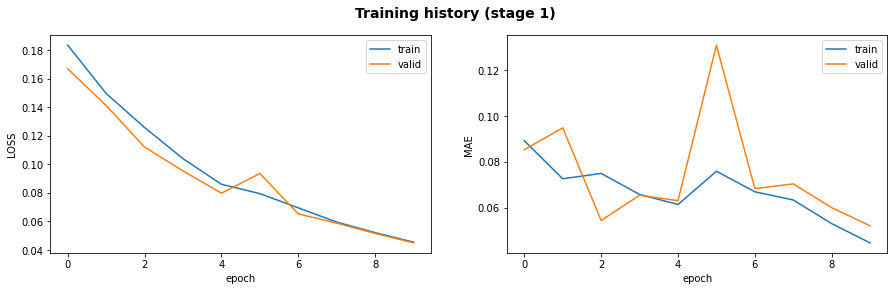

In [27]:
train_hist = pickle.load(open("train_history_aug.pkl","rb"))
plot_train_history(train_hist)

In [33]:
# Evaluate the model.
saved_model = load_model('aug_model_checkpoint.h5')
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)

62/62 [==============================] - 5s 77ms/step
MAE = 5.84102833
Age analysis:
Size group 1 = 369, MAE = 5.1952972412109375
Size group 2 = 1044, MAE = 5.026954174041748
Size group 3 = 390, MAE = 6.083358287811279
Size group 4 = 175, MAE = 11.519082069396973
---------
Age bias (Ba) = 3.3940741221110025
Gender analysis:
Size group female = 1020, MAE = 6.111274719238281
Size group male = 958, MAE = 5.553293228149414
---------
Gender bias (Bg) = 0.5579814910888672
Ethnicity Analysis:
Size group asian = 129, MAE = 6.38446044921875
Size group afroamerican = 56, MAE = 6.214773654937744
Size group caucasian = 1793, MAE = 5.790257453918457
---------
Ethnicity bias (Be) = 0.3961353302001953
Face experession Analysis:
Size group happy = 589, MAE = 6.1075215339660645
Size group slightlyhappy = 505, MAE = 5.677600860595703
Size group neutral = 756, MAE = 5.676927089691162
Size group other = 128, MAE = 6.228739261627197
---------
Face Expression bias (Bf) =  0.34755953152974445


## Weighted samples
First, we will generate a weight for each age group (for g = 1 to 4); The formula used to calculate the weight for each group $j$ is $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

Where:
- $w_j$ is the weight for each group $j$,
- $n_{samples}$ is the number of samples in the train set,
- $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
- $n_{samples,j}$ is the number of samples of class (group) $j$.


In [34]:
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100 

preprocess_X(X_train)

# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for y in Y_train:
    age = y * 100
    if age < 20:
        g1 +=1
    elif 20 <= age < 40:
        g2 +=1
    elif 40 <= age < 60:
        g3 +=1
    elif age >= 60:
        g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# Generating the weights for each group using the equation defined above.
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# Creating a vector with same size as Y_train, 
# that will link a particular label to its weight.
sample_weights = []
for y in Y_train:
    age = y * 100
    if age < 20:
        sample_weights.append(w[0])
    elif 20 <= age < 40:
        sample_weights.append(w[1])
    elif 40 <= age < 60:
        sample_weights.append(w[2])
    elif age >= 60:
        sample_weights.append(w[3])
sample_weights = np.array(sample_weights)

group(s) size =  [796, 2389, 732, 148]
weights per group =  [1.27669598 0.42538719 1.38831967 6.86655405]


### Training the model with weighted samples

In [35]:
saved_model = load_model(root_dir / 'model_checkpoint_2.h5')
saved_model.trainable = True

es = EarlyStopping(
    monitor='val_mae', 
    mode='min', 
    verbose=1, 
    patience=10,
)
mc = ModelCheckpoint(
    'weighted_model_checkpoint.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae'],
)

history = saved_model.fit(
    X_train, Y_train, 
    sample_weight=sample_weights, 
    validation_data=(X_valid, Y_valid), 
    batch_size=16, 
    epochs=10, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

with open('train_history_weighted.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
255/255 [==============================] - 58s 197ms/step - loss: 0.2055 - mae: 0.1080 - val_loss: 0.1997 - val_mae: 0.1209 - lr: 1.0000e-04
Epoch 2/10
255/255 [==============================] - 46s 182ms/step - loss: 0.1910 - mae: 0.0899 - val_loss: 0.2009 - val_mae: 0.1224 - lr: 1.0000e-04
Epoch 3/10
255/255 [==============================] - 48s 188ms/step - loss: 0.1832 - mae: 0.0798 - val_loss: 0.1880 - val_mae: 0.1101 - lr: 1.0000e-04
Epoch 4/10
255/255 [==============================] - 48s 187ms/step - loss: 0.1745 - mae: 0.0713 - val_loss: 0.1720 - val_mae: 0.0695 - lr: 1.0000e-04
Epoch 5/10
255/255 [==============================] - 48s 187ms/step - loss: 0.1670 - mae: 0.0660 - val_loss: 0.1628 - val_mae: 0.0595 - lr: 1.0000e-04
Epoch 6/10
255/255 [==============================] - 46s 182ms/step - loss: 0.1593 - mae: 0.0645 - val_loss: 0.1610 - val_mae: 0.0798 - lr: 1.0000e-04
Epoch 7/10
255/255 [==============================] - 48s 187ms/step - loss: 0.1517 - ma

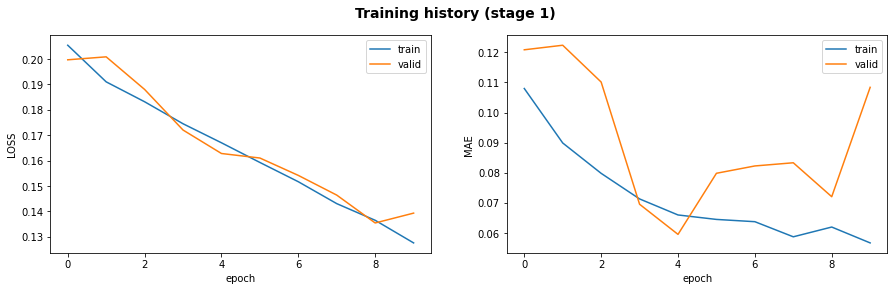

In [36]:
train_hist = pickle.load(open("train_history_weighted.pkl","rb"))
plot_train_history(train_hist)

In [37]:
# Evaluate the model.
saved_model = load_model('weighted_model_checkpoint.h5')
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)

62/62 [==============================] - 5s 76ms/step
MAE = 6.32913631
Age analysis:
Size group 1 = 369, MAE = 5.381131172180176
Size group 2 = 1044, MAE = 6.6175689697265625
Size group 3 = 390, MAE = 5.918563365936279
Size group 4 = 175, MAE = 7.522353649139404
---------
Age bias (Ba) = 1.1871121724446614
Gender analysis:
Size group female = 1020, MAE = 6.256823539733887
Size group male = 958, MAE = 6.406128883361816
---------
Gender bias (Bg) = 0.1493053436279297
Ethnicity Analysis:
Size group asian = 129, MAE = 6.602138519287109
Size group afroamerican = 56, MAE = 5.392519950866699
Size group caucasian = 1793, MAE = 6.338747978210449
---------
Ethnicity bias (Be) = 0.8064123789469401
Face experession Analysis:
Size group happy = 589, MAE = 6.84820032119751
Size group slightlyhappy = 505, MAE = 6.356997489929199
Size group neutral = 756, MAE = 5.8290324211120605
Size group other = 128, MAE = 6.78444766998291
---------
Face Expression bias (Bf) =  0.5808256467183431
